In [ ]:
import pm4py
import pandas as pd
from core_simulator import SimulationEngine

# 1. Load the BPMN Model
bpmn_path = "BPMN.bpmn" 
bpmn_graph = pm4py.read_bpmn(bpmn_path)
net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_graph)

# 2. Instantiate the Simulator
simulator = SimulationEngine(net, initial_marking, final_marking)

# 3. Run the Simulation
print("Running simulation...")
simulated_log_data = simulator.run_simulation()

print(f"Simulation complete. Generated {len(simulated_log_data)} traces.")

# 4. Convert to DataFrame to Check Transitions
flat_events = []
for trace in simulated_log_data:
    case_id = trace['attributes']['concept:name']
    amount = trace['attributes']['RequestedAmount']
    loan_goal = trace['attributes']['LoanGoal']
    
    
    for event in trace['events']:
        flat_events.append({
            'CaseID': case_id,
            'Activity': event['concept:name'],
            'Timestamp': event['time:timestamp'],
            'Resource': event['org:resource'],
            'LoanGoal': loan_goal,
            'Amount': amount
        })

df_simulated = pd.DataFrame(flat_events) 


Loaded organizational model:
Simple permissions: 26 activities
Context permissions: 401 contexts
Loading decision model with Fatigue Factor: 0.01
Model loaded
Running simulation...
Generated 29595 arrivals based on dynamic rates.
Simulation complete. Generated 29595 traces.


In [2]:
log_path = '/Users/moritz_hawener/Documents/Work/Studium/Master/WS25/BPI/BPI Challenge 2017_1_all/BPI Challenge 2017.xes.gz'
log = pm4py.read_xes(log_path)

/opt/miniconda3/envs/bpi/lib/python3.12/site-packages/pm4py/utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
/opt/miniconda3/envs/bpi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:33<00:00, 951.59it/s] 


In [ ]:
# 1. Get list of all unique activities
all_activities = df_simulated['Activity'].unique()

print(f"--- Transition Probabilities (Percentage) ---")

for act in sorted(all_activities):
    mask = df_simulated['Activity'] == act
    indices = df_simulated.index[mask]
    
    valid_indices = [i for i in indices if i + 1 < len(df_simulated)]
    
    next_events = []
    for i in valid_indices:
        current_case = df_simulated.at[i, 'CaseID']
        next_case = df_simulated.at[i+1, 'CaseID']
        
        if current_case == next_case:
            next_events.append(df_simulated.at[i+1, 'Activity'])
        else:
            next_events.append("(End of Case)")

    if next_events:
        dist = pd.Series(next_events).value_counts(normalize=True) * 100
        
        print(f"\n[ {act} ] followed by:")
        print(dist.apply(lambda x: f"{x:.1f}%"))
    else:
        print(f"\n[ {act} ] is always the last event.") 

--- Transition Probabilities (Percentage) ---

[ A_Accepted ] followed by:
O_Create Offer    100.0%
Name: proportion, dtype: object

[ A_Cancelled ] followed by:
O_Cancelled    100.0%
Name: proportion, dtype: object

[ A_Complete ] followed by:
W_Call after offers    100.0%
Name: proportion, dtype: object

[ A_Concept ] followed by:
W_Complete application    67.0%
A_Accepted                33.0%
Name: proportion, dtype: object

[ A_Create Application ] followed by:
A_Submitted               64.7%
W_Complete application    35.3%
Name: proportion, dtype: object

[ A_Denied ] followed by:
(End of Case)    100.0%
Name: proportion, dtype: object

[ A_Pending ] followed by:
W_Validate application    100.0%
Name: proportion, dtype: object

[ A_Submitted ] followed by:
W_Handle leads    100.0%
Name: proportion, dtype: object

[ A_Validating ] followed by:
O_Returned    100.0%
Name: proportion, dtype: object

[ O_Accepted ] followed by:
A_Pending    100.0%
Name: proportion, dtype: object

[ O_C


--- Statistical Comparison (Trace Lengths) ---
  Dataset  Count  Mean  Median  Std Dev  Min  Max  95% CI Lower  95% CI Upper
   Actual  31509 38.16    35.0    16.72   10  180         37.97         38.34
Simulated  29595 45.65    39.0    26.18    8  398         45.35         45.95


/var/folders/rz/nvdgk3v95fxdx4m351hjk33w0000gn/T/ipykernel_29853/3851347647.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Type', y='Length', ax=axes[0], palette="Set2")


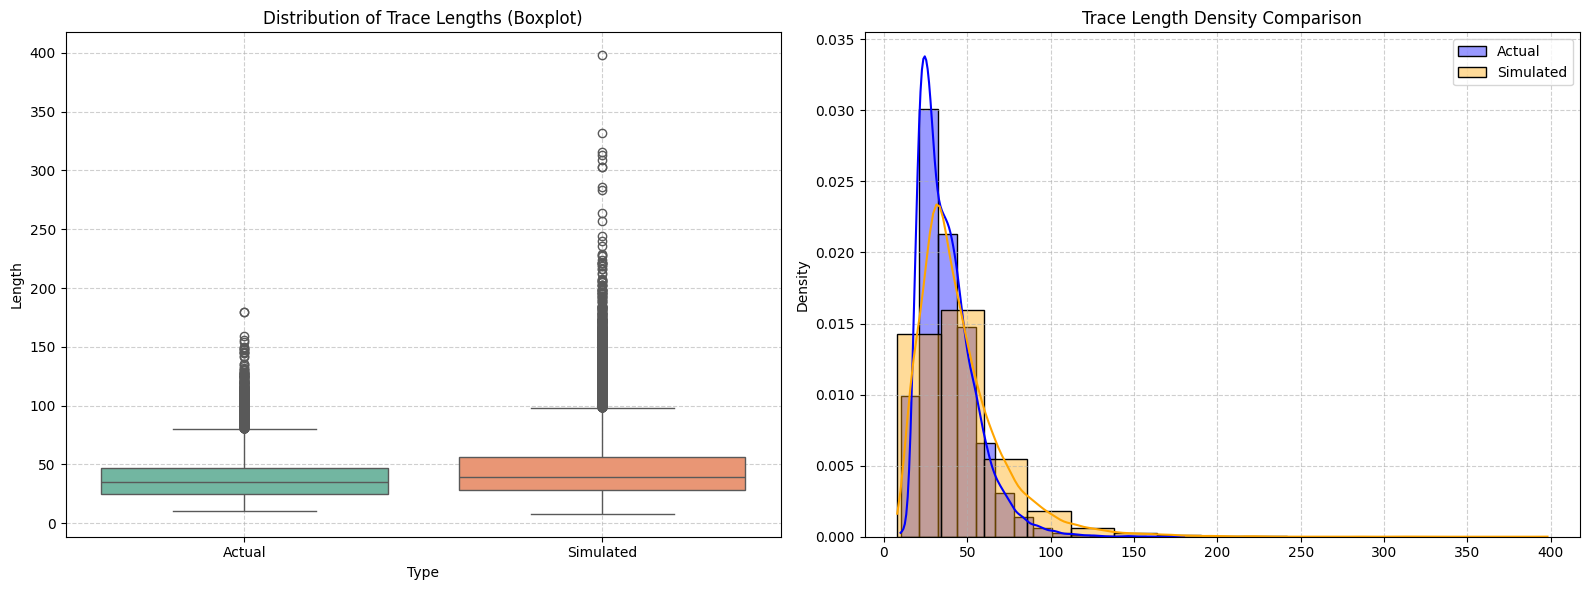

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

def compare_logs(original_log, sim_df):
    # 1. Actual Data
    if not isinstance(original_log, pd.DataFrame):
        print("Converting original log to DataFrame...")
        df_actual = pm4py.convert_to_dataframe(original_log)
    else:
        df_actual = original_log.copy()

    actual_lengths = df_actual.groupby('case:concept:name').size()
    sim_lengths = sim_df.groupby('CaseID').size()

    # 2. Statistical Summary
    def get_stats(data, label):
        mean = np.mean(data)
        median = np.median(data)
        std = np.std(data)
        # 95% Confidence Interval for the Mean
        ci = stats.t.interval(0.95, len(data)-1, loc=mean, scale=stats.sem(data))
        return {
            'Dataset': label,
            'Count': len(data),
            'Mean': round(mean, 2),
            'Median': round(median, 2),
            'Std Dev': round(std, 2),
            'Min': np.min(data),
            'Max': np.max(data),
            '95% CI Lower': round(ci[0], 2),
            '95% CI Upper': round(ci[1], 2)
        }

    stats_actual = get_stats(actual_lengths, "Actual")
    stats_sim = get_stats(sim_lengths, "Simulated")
    
    summary_df = pd.DataFrame([stats_actual, stats_sim])
    
    print("\n--- Statistical Comparison (Trace Lengths) ---")
    print(summary_df.to_string(index=False))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Boxplot (Overall Distribution)
    plot_data = pd.DataFrame({
        'Length': np.concatenate([actual_lengths, sim_lengths]),
        'Type': ['Actual'] * len(actual_lengths) + ['Simulated'] * len(sim_lengths)
    })
    
    sns.boxplot(data=plot_data, x='Type', y='Length', ax=axes[0], palette="Set2")
    axes[0].set_title("Distribution of Trace Lengths (Boxplot)")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # KDE / Histogram (Shape)
    sns.histplot(actual_lengths, color="blue", label="Actual", kde=True, stat="density", ax=axes[1], alpha=0.4, bins=15)
    sns.histplot(sim_lengths, color="orange", label="Simulated", kde=True, stat="density", ax=axes[1], alpha=0.4, bins=15)
    axes[1].set_title("Trace Length Density Comparison")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

compare_logs(log, df_simulated) 